# Substructures
- plot AoLP for substructures after deconvolution
- percentage of polarimetric signal on substructure

## Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties


def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    
def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        

    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent



def unres_correction(iq,iu,q,u):

    n=q.shape[0]
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)
    i=(iq+iu)/2
    mask=(R<=3)

    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    q_corr=q-cq*iq
    u_corr=u-cu*iu

    q_phi=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
    q_phi= (q_phi> 0)*q_phi +  (q_phi <=0 )*1e-10
    u_phi=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
    pi=np.sqrt(q_corr*q_corr+u_corr*u_corr)
    aolp=0.5*np.arctan2(u, q)+np.pi/2

    return iq,q_corr,iu,u_corr,i,q_phi,u_phi,pi,aolp,R,phi



def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i


   
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n


def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout
    
def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def northeast2(lim,ps,coef=1):
    x_ar=(lim-3) * ps
    y_ar=(-lim+3) * ps
    plt.arrow(x_ar, y_ar, 0, 3*coef*ps, color='white',width=1,head_width=8, length_includes_head=True,head_length=12)
    plt.text(x_ar-0.5*coef * ps,y_ar+3.2*coef * ps,'N',fontsize=16,color="white")        
    plt.arrow(x_ar, y_ar, -3*coef*ps, 0, color='white',width=1,head_width=8, length_includes_head=True,head_length=12)
    plt.text(x_ar-4.2 *coef* ps,y_ar-0.2 *coef* ps,'E',fontsize=16,color="white") 


def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim, star, annulus):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    
    
    # First, we plot the background image
    if star=='HR4049_combined':
        fig = plt.figure(figsize=(8,7))
    else:
        fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='upper',extent=(-d, d, d, -d))
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    
    
    plt.xlabel('mas',fontsize=24)
    plt.ylabel("mas",fontsize=24)
     
    ax.tick_params(axis='both',labelsize=20)
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [5, 5]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    
    
    #mask1=mask1.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac[frac<=np.max(frac)] =np.max(frac)
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*3*factor[0]*factor[1]
    mask=mask2#*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2)*80*ps # X-vector 
    pixY = frac*np.sin(psi+np.pi/2)*80*ps # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w',width=0.005,scale_units='xy', scale=1)
    ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask], **quiveropts)

    northeast2(lim-5,ps,coef=7)
    lenghtperc=0.5

    lenghtmas=lenghtperc*80*ps
    fp = FontProperties()
    fp.set_size(16)
    asb = AnchoredSizeBar(ax.transData,
                          lenghtmas,
                          r"0.5%",fontproperties=fp,
                          loc='lower left',
                          pad=0.1, borderpad=0.6, sep=5,size_vertical=2,
                          frameon=False, color='white')
    ax.add_artist(asb)
    
    
    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    #CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title,fontsize=28)
    

    if star=='HR4049_combined':
        if annulus=='I':
            ax.text(-0.4, 0.5, annulus+"'-band", transform=ax.transAxes, fontsize=28, va='center', rotation=90)

        else:
            ax.text(-0.4, 0.5, annulus+'-band', transform=ax.transAxes, fontsize=28, va='center', rotation=90)

    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n

## Set up


In [2]:
#For fits
#out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
#out_fits.writeto(dirName+star+'_'+annulus+'_'+fittype+'_decon.fits', overwrite = True)                       # write output

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','01.SCI_AR_Pup']
stars=['01.SCI_AR_Pup','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya']
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'01.SCI_AR_Pup':[75,45],'UMon':[25,144],'UMon_Katya':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

starnames = {'HD75885':'HD75885','01.SCI_AR_Pup':'AR Pup','HR4049_combined':'HR4049','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}

#stars = ['IRAS08544-4431','IRAS08544-4431_dc_notnorm','UMon']
star = '01.SCI_AR_Pup'

incl_pa=disk_incl_pa[star]
fittypes=['1', '2']

band=['V','I']
ps=3.6


## SUBSTRUCTURES: DECONVOLVED DATA +AOLP

### Proportional size of vectors

1024


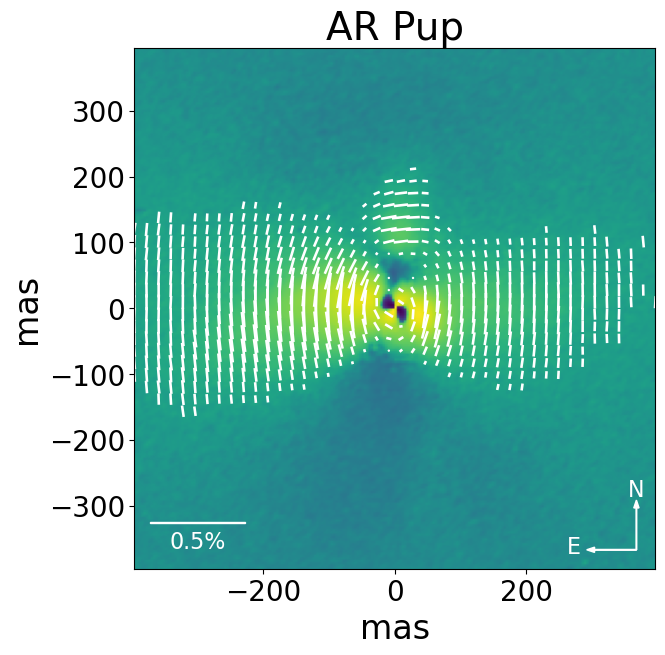

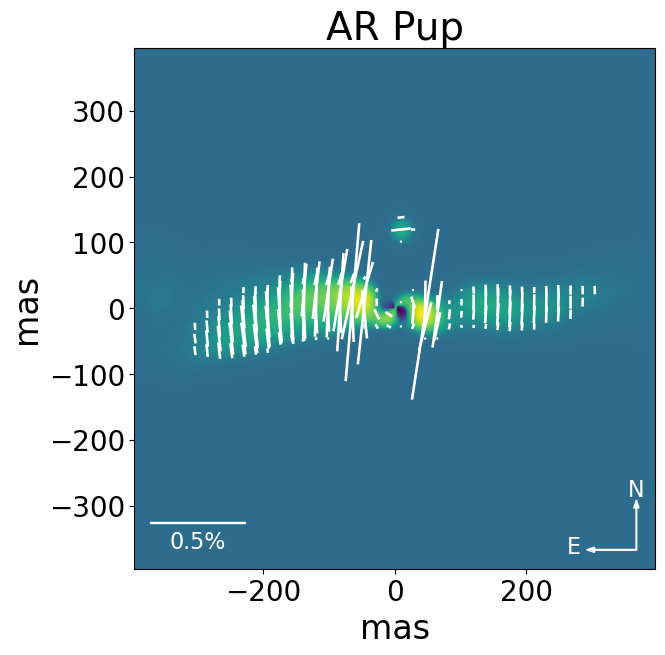

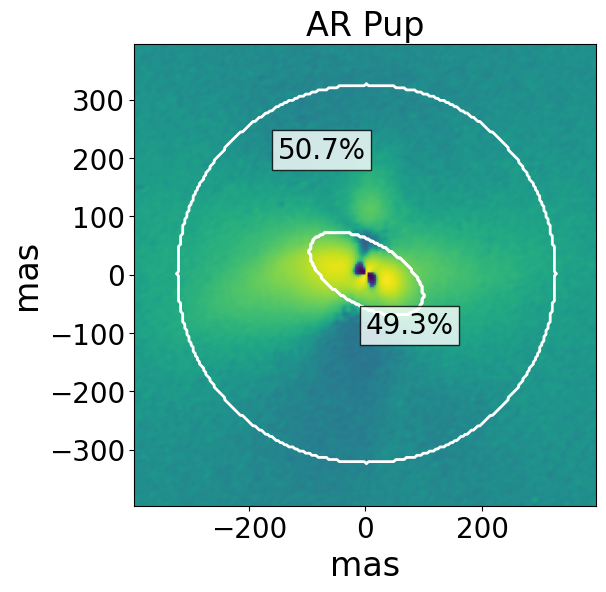

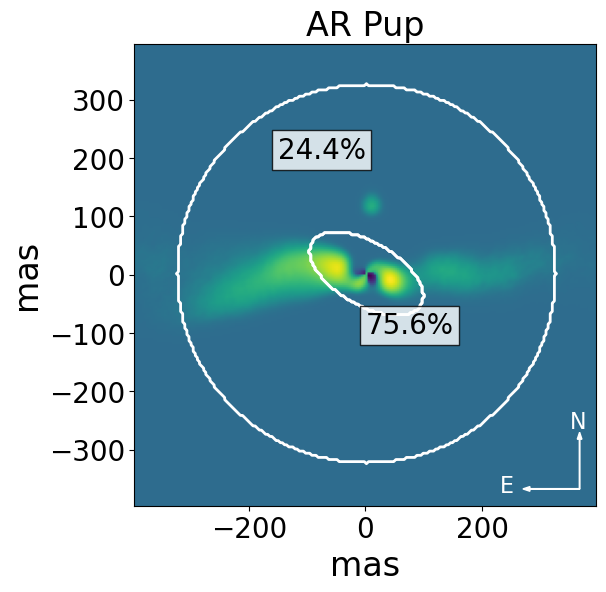

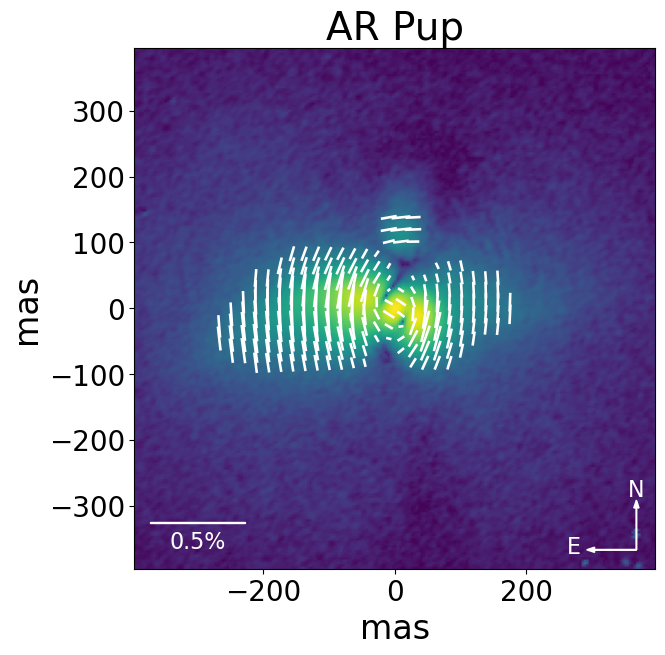

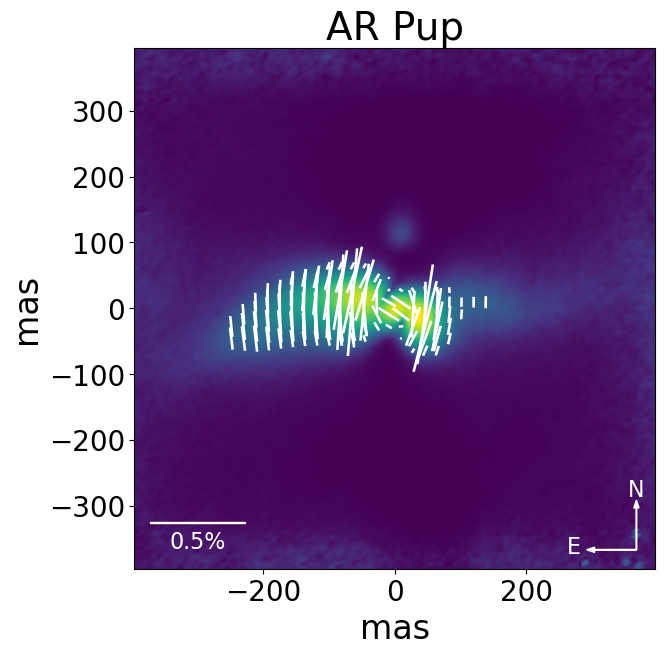

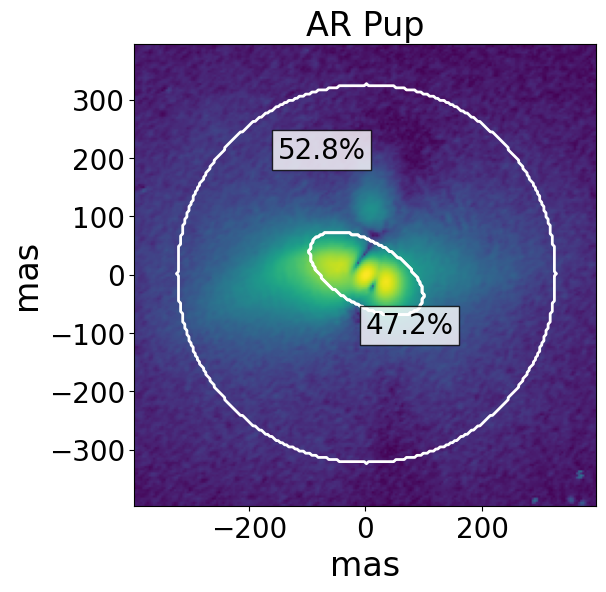

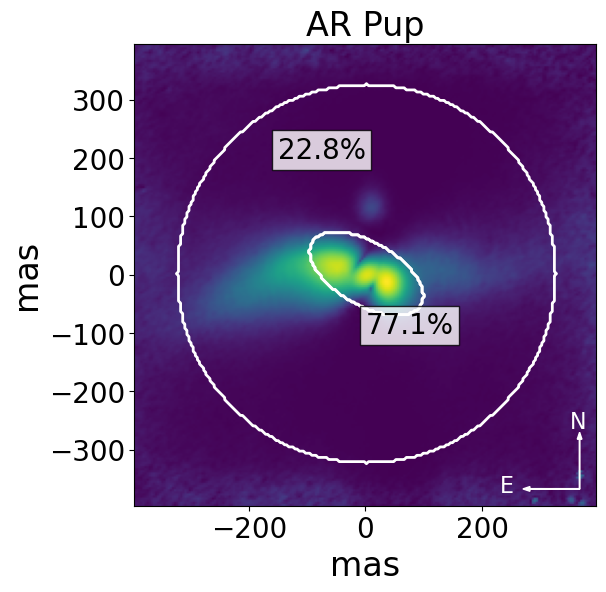

1024


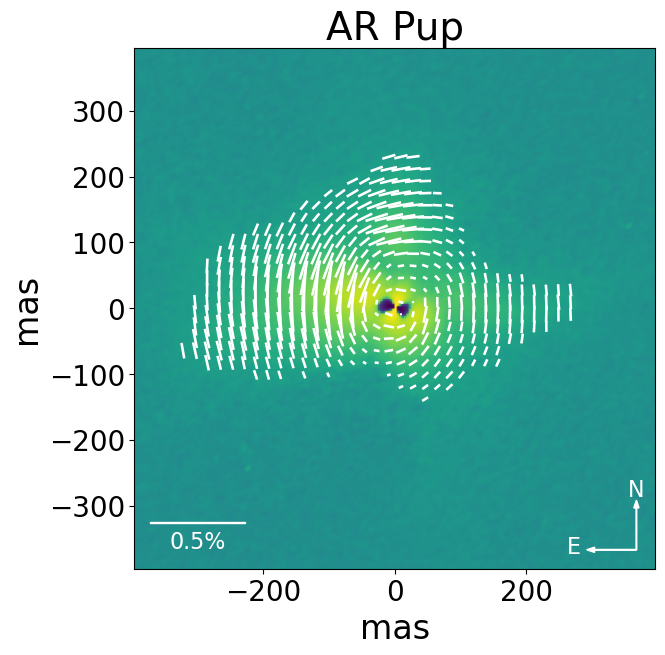

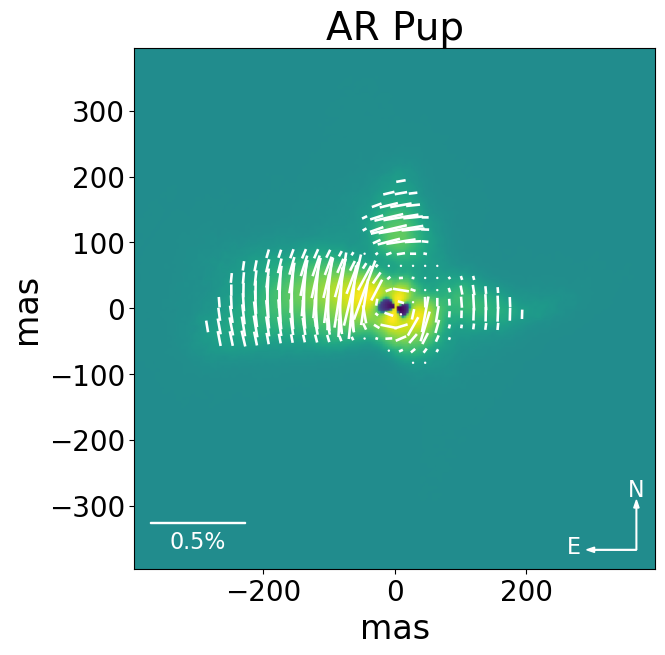

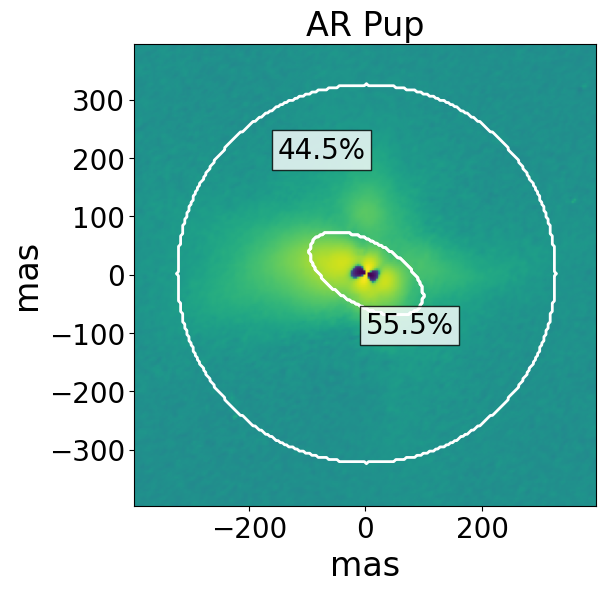

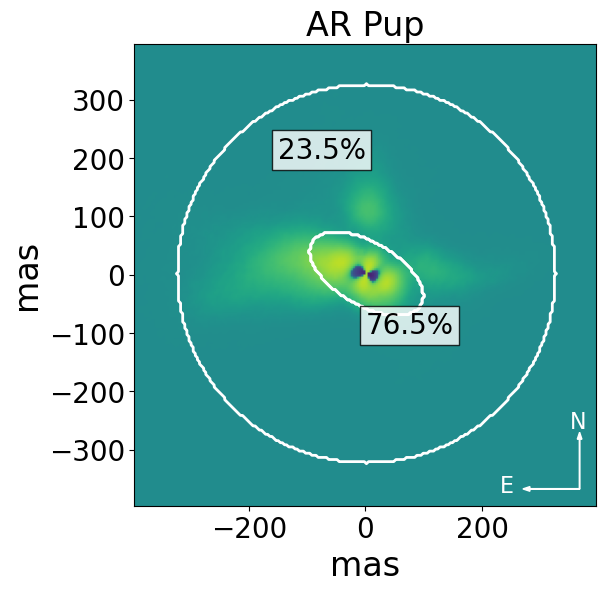

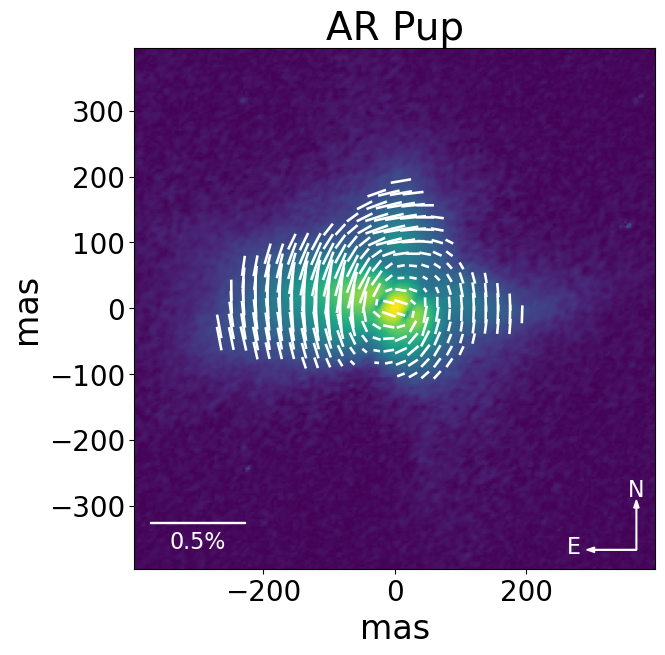

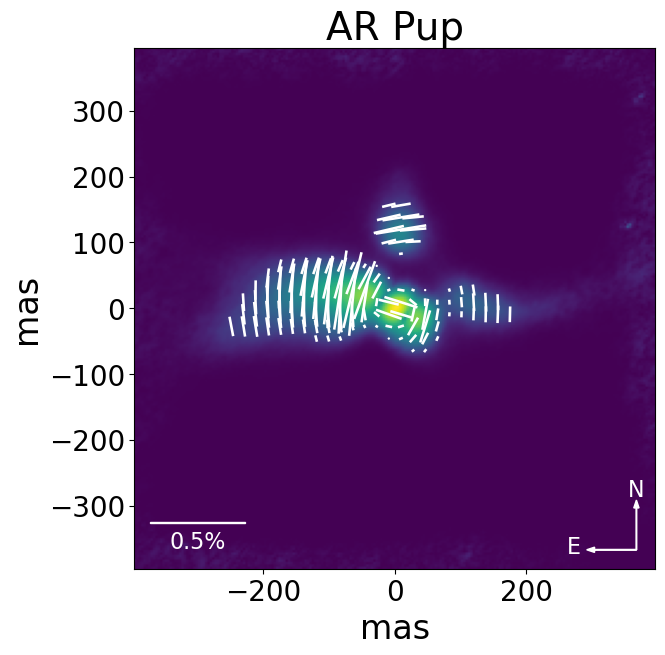

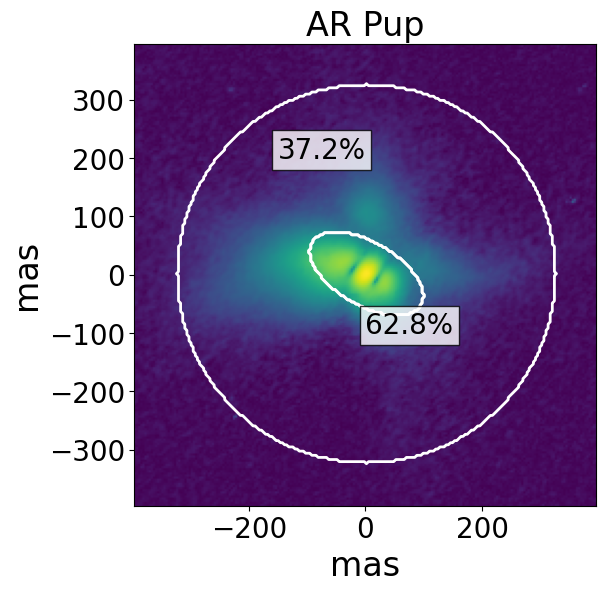

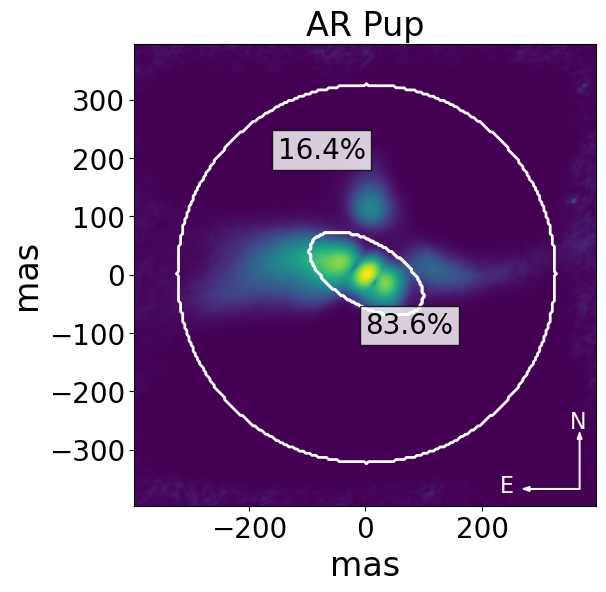

In [3]:


dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/ZIMPOL/'
dirdatI='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'
figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Substructures/'
createfolder(figfolder)


#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:
    
    datafr=pd.read_csv(dirdatI+star+'_'+band[int(fittype)-1]+'_df_out.csv')
    

    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    Q=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'Q'+'_corr_tel+unres.fits')
    U=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'U'+'_corr_tel+unres.fits')
    
    PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
    Q_phi_dec, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'PI'+'/'
    PI_dec, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    Q_phi=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'Q_phi'+'_corr_tel+unres.fits')
    PI=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_corr_tel+unres.fits')

    
    
    mask=(R<=1500/ps)
    PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)
    d = n * ps / 2
    if star=='V709_Car':
        lim=60
    elif star=='01.SCI_AR_Pup':
        lim=110
    else:
        lim=40
    
    for polartype in ['Q_phi', 'PI']:
        
        if polartype=='PI': 
            Q_phi=np.copy(PI)
            Q_phi_dec=np.copy(PI_dec)
            noise=datafr.xs('noise_pi_median',axis=1).median()
        else:
            noise=datafr.xs('noise_q_phi_median',axis=1).median()
        
        if band[int(fittype)-1]=='I':
            plot_AoLP(ps,Q,U,R,I,Q_phi,starnames[star],figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_aolp.png',True, noise,lim,star,band[int(fittype)-1])
            plot_AoLP(ps,Q,U,R,I,Q_phi_dec,starnames[star],figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_deconv_aolp.png',True, noise,lim,star,band[int(fittype)-1])

        else:
            plot_AoLP(ps,Q,U,R,I,Q_phi,starnames[star],figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_aolp.png',True, noise,lim,star,band[int(fittype)-1])
            plot_AoLP(ps,Q,U,R,I,Q_phi_dec,starnames[star],figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_deconv_aolp.png',True, noise,lim,star,band[int(fittype)-1])



        

         # Define ellipse parameters
        center = (0.5, 0.5)  # Center coordinates (x, y)
        
        stars_c=['01.SCI_AR_Pup','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya','UMon']

        if star==stars_c[1] or star==stars_c[2] or star==stars_c[3]: 
            position_angle = 54  # Position angle (orientation) of the ellipse (in degrees)
            sini=np.cos(np.deg2rad(26))
            maxis=13.5
            maxis2=35
        elif star==stars_c[4] : 
            position_angle = 177  # Position angle (orientation) of the ellipse (in degrees)
            sini=np.cos(np.deg2rad(20))
            maxis=14
            maxis2=50
        elif star==stars_c[5] : 
            position_angle = 14  # Position angle (orientation) of the ellipse (in degrees)
            sini=np.cos(np.deg2rad(40))
            maxis=12
            maxis2=35
        elif star==stars_c[6] : 
            position_angle = 40  # Position angle (orientation) of the ellipse (in degrees)
            sini=np.cos(np.deg2rad(40))
            maxis=12
            maxis2=35
        elif star==stars_c[0] : 
            position_angle = 150  # Position angle (orientation) of the ellipse (in degrees)
            sini=np.cos(np.deg2rad(60))
            maxis=30
            maxis2=90



         # Calculate the ellipse mask with the specified position angle
        a = np.deg2rad(position_angle)
        cos_a = np.cos(a)
        sin_a = np.sin(a)
        
        axes = (maxis, int(maxis*sini))  # Major and minor axis lengths
        # Generate the ellipse mask with rotation
        mask1 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1

        
        axes = (maxis2, int(maxis2))  # Major and minor axis lengths
        # Generate the ellipse mask with rotation
        mask2 = ((X - center[0]) * cos_a + (Y - center[1]) * sin_a)**2 / axes[0]**2 + ((X - center[0]) * sin_a - (Y - center[1]) * cos_a)**2 / axes[1]**2 <= 1
        correction= mask2==mask1

        mask2[correction==1]=0    


        maskall = (R < maxis2)
        pol_rat_decon_q1=np.sum(Q_phi[mask1])/np.sum(Q_phi[maskall])
        pol_rat_decon_q2=np.sum(Q_phi[mask2])/np.sum(Q_phi[maskall])

        image_q_phi_arcs=Q_phi*1
        #image_q_phi_arcs[mask1]=300
        #image_q_phi_arcs[mask2]=10



        image=image_q_phi_arcs  
        if star=='HR4049_combined':
            fig, ax = plt.subplots(1, 1,figsize=(8,7))
        else:
            fig, ax = plt.subplots(1, 1,figsize=(8,6))
        image = np.arcsinh(image)
        max = np.max(image)
        min=np.min(image)
        plt.imshow(image, vmin=min, vmax=max,extent=(-d, d, d, -d))

        ax.contour(mask1, colors='white',origin='image',extent=(-d, d, d, -d),linewidths=2)
        ax.contour(mask2, colors='white',origin='image',extent=(-d, d, d, -d),linewidths=2)
        plt.xlim(-lim*ps, lim*ps)
        plt.ylim(-lim*ps, lim*ps)
        t1=plt.text(0, -100, str(round(pol_rat_decon_q1*100,1))+'%',backgroundcolor='white',fontsize=20,color='black')
        t2=plt.text(-150, 200, str(round(pol_rat_decon_q2*100,1))+'%',backgroundcolor='white',fontsize=20,color='black')

        for t in [t1,t2]: t.set_bbox(dict(facecolor='white', alpha=0.8))            
        #plt.text(50, -295, 'total '+str(round((pol_rat_decon_q1+pol_rat_decon_q2+pol_rat_decon_q3)*100,3))+'%',backgroundcolor='white',fontsize=20)
        plt.xlabel('mas', fontsize=24)
        plt.ylabel('mas', fontsize=24)
        plt.title(starnames[star], fontsize=24)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20) 
        
        plt.savefig(figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_substr_perc.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        
        
        
        
        pol_rat_decon_q1=np.sum(Q_phi_dec[mask1])/np.sum(Q_phi_dec[maskall])
        pol_rat_decon_q2=np.sum(Q_phi_dec[mask2])/np.sum(Q_phi_dec[maskall])
        image_q_phi_arcs=Q_phi_dec*1
        image=image_q_phi_arcs  
        if star=='HR4049_combined':
            fig, ax = plt.subplots(1, 1,figsize=(8,7))
        else:
            fig, ax = plt.subplots(1, 1,figsize=(8,6))
        image = np.arcsinh(image)
        max = np.max(image)
        min=np.min(image)
        plt.imshow(image, vmin=min, vmax=max,extent=(-d, d, d, -d))

        ax.contour(mask1, colors='white',origin='image',extent=(-d, d, d, -d),linewidths=2)
        ax.contour(mask2, colors='white',origin='image',extent=(-d, d, d, -d),linewidths=2)
        plt.xlim(-lim*ps, lim*ps)
        plt.ylim(-lim*ps, lim*ps)
        t1=plt.text(0, -100, str(round(pol_rat_decon_q1*100,1))+'%',backgroundcolor='white',fontsize=20,color='black')
        t2=plt.text(-150, 200, str(round(pol_rat_decon_q2*100,1))+'%',backgroundcolor='white',fontsize=20,color='black')
        northeast2(lim-5,ps,coef=9)
   
        for t in [t1,t2]: t.set_bbox(dict(facecolor='white', alpha=0.8))            
        #plt.text(50, -295, 'total '+str(round((pol_rat_decon_q1+pol_rat_decon_q2+pol_rat_decon_q3)*100,3))+'%',backgroundcolor='white',fontsize=20)
        plt.xlabel('mas', fontsize=24)
        plt.ylabel('mas', fontsize=24)
        plt.title(starnames[star], fontsize=24)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20) 
        if star=='HR4049_combined':
            if band[int(fittype)-1]=='I':
                ax.text(-0.4, 0.5, band[int(fittype)-1]+"'-band", transform=ax.transAxes, fontsize=28, va='center', rotation=90)

            else:
                ax.text(-0.4, 0.5, band[int(fittype)-1]+'-band', transform=ax.transAxes, fontsize=28, va='center', rotation=90)

        plt.savefig(figfolder+star+'_'+polartype+'_'+band[int(fittype)-1]+'_substr_perc_deconv.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


